Original dataset => https://www.kaggle.com/kazanova/sentiment140

In [1]:
import tensorflow as tf
import csv
import random
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

In [2]:
trainig_file = 'training_cleaned.csv'
if os.path.isfile(trainig_file):
    print(trainig_file + " exists")
# You can download it manually from => 'https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ'

training_cleaned.csv exists


In [3]:
corpus = []
with open('training_cleaned.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for col in reader:
        list_item=[]
        list_item.append(col[5]) #Get sentence from col[5]
        this_label=col[0] #Get label from col[0] 
        if this_label=='0':
            list_item.append(0) 
        else:
            list_item.append(1)
        corpus.append(list_item) # list of the sentence with labels ['sentence', label]

In [4]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=1600000
test_portion=.1

# This cell will take time 

In [5]:
sentences = []
labels = []
random.shuffle(corpus)
for i in range(training_size):
    sentences.append(corpus[i][0])
    labels.append(corpus[i][1])
    
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index #Dict {"word":index}
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

# Split Data
split = int(test_portion * training_size)
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [6]:
print('We have {} sentences.'.format(len(sentences)))
print('For example: \n',sentences[1])
print('The same sentence after convert it to numbers: \n',sequences[1])
print('Sentence with padding: \n',padded[1])

We have 1600000 sentences.
For example: 
 So today is officially June! Very tired. Still sick. Not really looking forward to class. Can't I take my bed with me? 
The same sentence after convert it to numbers: 
 [15, 40, 8, 912, 577, 120, 182, 73, 187, 24, 63, 218, 397, 2, 445, 69, 1, 173, 5, 143, 21, 14]
Sentence with padding: 
 [ 15  40   8 912 577 120 182  73 187  24  63 218 397   2 445  69]


In [8]:
glove_file = 'glove.6B.100d.txt'
if os.path.isfile(glove_file):
    print(glove_file + " exists")
# You can download it manually from => 'https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g'

glove.6B.100d.txt exists


In [9]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f: # vector representations for words [word, 100 features]
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            continue

In [10]:
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for word,i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # Matrix of representation of words [1600000, 100]
print(len(embedding_matrix))

690966


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length,weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           69096600  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [13]:
epochs = 50
history = model.fit(x=np.array(training_sequences),
                    y=np.array(training_labels),
                    epochs=epochs,
                    validation_data=(np.array(test_sequences), np.array(test_labels)), verbose=1)


Epoch 1/50
45000/45000 [==============================] - 470s 10ms/step - loss: 0.5397 - accuracy: 0.7205 - val_loss: 0.5053 - val_accuracy: 0.7477
Epoch 2/50
45000/45000 [==============================] - 425s 9ms/step - loss: 0.5152 - accuracy: 0.7397 - val_loss: 0.4954 - val_accuracy: 0.7542
Epoch 3/50
45000/45000 [==============================] - 497s 11ms/step - loss: 0.5081 - accuracy: 0.7442 - val_loss: 0.4909 - val_accuracy: 0.7574
Epoch 4/50
45000/45000 [==============================] - 505s 11ms/step - loss: 0.5048 - accuracy: 0.7468 - val_loss: 0.4910 - val_accuracy: 0.7578
Epoch 5/50
45000/45000 [==============================] - 625s 14ms/step - loss: 0.5022 - accuracy: 0.7488 - val_loss: 0.4895 - val_accuracy: 0.7586
Epoch 6/50
45000/45000 [==============================] - 654s 15ms/step - loss: 0.5006 - accuracy: 0.7502 - val_loss: 0.4868 - val_accuracy: 0.7598
Epoch 7/50
45000/45000 [==============================] - 523s 12ms/step - loss: 0.4991 - accuracy: 0.7509 

In [15]:
model.save('weight')

INFO:tensorflow:Assets written to: weight\assets


INFO:tensorflow:Assets written to: weight\assets


In [16]:
model.save('weight.h5')

<Figure size 432x288 with 0 Axes>

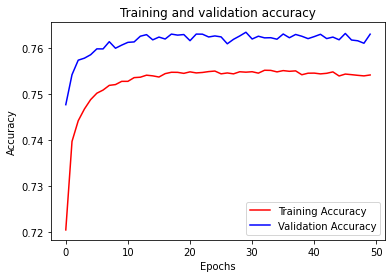

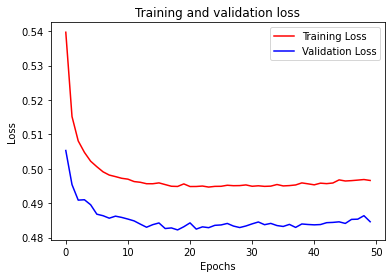

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

# Evaluation

In [71]:
x_test = np.array(test_sequences)
y_true = np.array(test_labels)
prediction = model.predict(x_test)
y_pred = [1 if x>0.5 else 0 for x in prediction]

In [112]:
ones = sum(y_pred)
zeros = 160000-ones

In [106]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[61303, 18818],
       [19098, 60781]], dtype=int64)

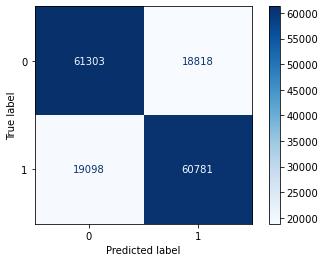

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
labels = ["0", "1"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [96]:
acc = 122084/(61303+18818+19098+60781)
print('Accuracy = ',acc)
precision = 61303/(61303+19098)
print('Precision = ', precision)
recall = 61303/(61303+18818)
print('Recall = ', recall)
f1_score = (2 * precision * recall) / (precision+recall)
print('F1 Score = ',f1_score)

Accuracy =  0.763025
Precision =  0.7624656409746148
Recall =  0.7651302405112268
F1 Score =  0.7637956168001895


In [98]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ =  precision_recall_fscore_support(y_true, y_pred, average='macro')
print('Accuracy = ',acc)
print('Recall = ', recall)
print('Precision = ', precision)
print('F1 Score = ',f1_score)

Accuracy =  0.763025
Recall =  0.7630218110003648
Precision =  0.7630278179118981
F1 Score =  0.7630224776334686


In [78]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='weighted')

0.7630236470064582

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2]